Important Libraries.

In [1]:
import os
import re
import cv2
import time
import shutil
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


Loading Dataset.

In [ ]:
training_data_directory = '/content/drive/MyDrive/Soil_images/Train'
test_data_directory = '/content/drive/MyDrive/Soil_images/Test'

Pre Processing

In [ ]:
# Initiate data processing tools
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

# Load data into Python
training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 9605 images belonging to 4 classes.
Found 53 images belonging to 1 classes.


Model.


In [ ]:
# choose model parameters
num_conv_layers = 4
num_dense_layers = 4
layer_size = 32
num_training_epochs = 5
MODEL_NAME = 'soil'

Training model.

In [ ]:
# Initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convolutional layer
model.add(Conv2D(layer_size, (4, 4), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 4)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# add output layer
model.add(Dense(4))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

# use the data already loaded previously to train/tune the model
trainer=model.fit(training_data,
            epochs=num_training_epochs,
            validation_data = testing_data)
# save the trained model
model.save(f'{MODEL_NAME}.keras')

Epoch 1/5
165/301 [===============>..............] - ETA: 40:37 - loss: 0.2728 - accuracy: 0.9294

Prediction Testing.

In [4]:

def make_prediction(image_fp):
    # Load and display the image
    im = cv2.imread(image_fp)
    if im is not None:
        plt.imshow(im[:,:,[2,1,0]])
        plt.show()
    else:
        print("Image not found or unable to load.")
        return

    # Preprocess the image
    img = image.load_img(image_fp, target_size=(256, 256))
    img = image.img_to_array(img)
    image_array = img / 255.0
    img_batch = np.expand_dims(image_array, axis=0)

    # Define possible output values
    class_ = ["Alluvial soil", "Black Soil", "Clay soil", "Red soil"]

    # Make prediction
    predicted_value = class_[model.predict(img_batch).argmax()]

    # Extract the true value from the file path
    match = re.search(r'(Alluvial soil)|(Black Soil)|(Clay soil)|(Red soil)', image_fp)
    true_value = match[0] if match else "Unknown"

    # Output the results
    out = f"""Predicted Soil Type: {predicted_value}
True Soil Type: {true_value}
Correct?: {predicted_value == true_value}"""

    return out




Test image instance.

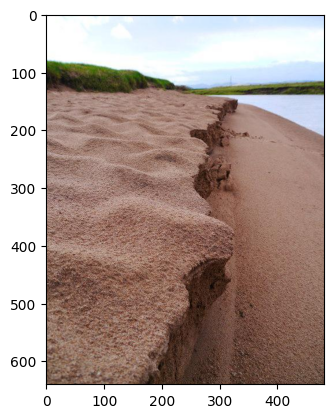

1/1 [==============================] - 0s 342ms/step
Predicted Soil Type: Red soil
True Soil Type: Unknown
Correct?: False


In [5]:
# Example usage
test_image_filepath = '/content/drive/MyDrive/Soil_images/Sample/92d1b796-1416-4209-8361-42289841df6f3986576519591075267.jpeg'
print(make_prediction(test_image_filepath))

Plotting image

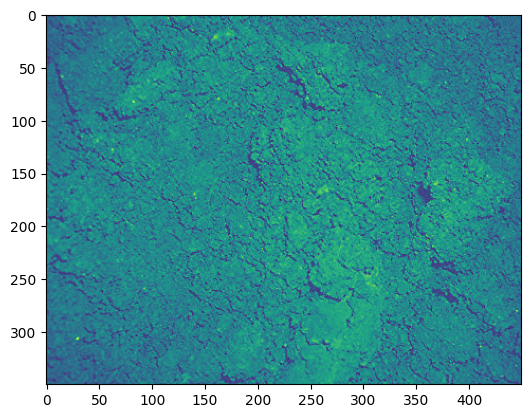

In [6]:
percentage_photo='/content/drive/MyDrive/Soil_images/Sample/Clay-Soil-1.jpg'

im = cv2.imread(percentage_photo) # load image
plt.imshow(im[:,:,[0]])

Split images

In [7]:
def split_images(image_dir, save_dir):
    classification_list = ['Alluvial soil', 'Black Soil', 'Clay soil','Red soil']
    for classification in classification_list:
        folder = image_dir + '/' + classification + '/'
        save_folder = save_dir + '/' + classification + '/'
        files = [f for f in listdir(folder) if isfile(join(folder, f))]

        for file in files:
            if '.ini' in file:
                continue
            fp = folder + file
            img = cv2.imread(fp)
            h,w,c = img.shape
            im_dim = 64
            # For cropping images
            for r in range(0,img.shape[0],im_dim):
                for c in range(0,img.shape[1],im_dim):
                    cropped_img = img[r:r+im_dim, c:c+im_dim,:]
                    ch, cw, cc = cropped_img.shape
                    if ch == im_dim and cw == im_dim:
                        write_path = f"{save_folder + str(randrange(100000))}img{r}_{c}.jpg"
                        cv2.imwrite(write_path,cropped_img)
                    else:
                        pass


Saving Splits

In [8]:
try:
    parent = training_data_directory.replace('Train', '')
    dirs = ['train_divided', 'test_divided']
    class_ = ["Alluvial soil", "Black Soil", "Clay soil","Red soil"]
    for dir in dirs:
        os.mkdir(os.path.join(parent, dir))
        for classification in class_:
            os.mkdir(os.path.join(parent, dir, classification))

    # split training images
    split_images(image_dir=training_data_directory,
                save_dir=training_data_directory.replace('Train', 'train_divided'))
    # split test images
    split_images(image_dir=test_data_directory,
                save_dir=test_data_directory.replace('Test', 'test_divided'))
except FileExistsError:
    pass

NameError: name 'training_data_directory' is not defined

Loading Saved model

In [2]:
model_fp = os.getcwd()+'/'+'soil.keras'
print(model_fp)
model = load_model(model_fp)

/content/soil.keras


Classify Image function

In [9]:
def classify_images(image_fp, model):
    classes = ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
    alluvial_count = 0
    Black_count = 0
    clay_count = 0
    red_count = 0

    img = cv2.imread(image_fp)
    img = cv2.resize(img, (1024, 1024))
    im_dim = 256

    for r in range(0, img.shape[0], im_dim):
        for c in range(0, img.shape[1], im_dim):
            cropped_img = img[r:r + im_dim, c:c + im_dim, :]
            h, w, c = cropped_img.shape
            if h == im_dim and w == im_dim:
                classification = model_classify(cropped_img, model)
                if classification == classes[0]:
                    alluvial_count += 1
                elif classification == classes[1]:
                    Black_count += 1
                elif classification == classes[2]:
                    clay_count += 1
                elif classification == classes[3]:
                    red_count += 1
            else:
                continue

    total_count = alluvial_count + Black_count + clay_count + red_count
    proportion_array = [alluvial_count / total_count, Black_count / total_count, clay_count / total_count, red_count / total_count]
    print(f"Counts: Alluvial: {alluvial_count}, Black: {Black_count}, Clay: {clay_count}, Red: {red_count}")
    return proportion_array

Model Classify

In [10]:
def model_classify(cropped_img, model):
    classes = ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']
    image_array = cropped_img / 255.0
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0]
    first_idx = np.argmax(prediction_array)
    first_class = classes[first_idx]
    print(f"Predicted probabilities: {prediction_array}, Predicted class: {first_class}")
    return first_class


Percentage of Classification

In [11]:
def classify_percentage(image_fp):
    start = time.time()
    out = classify_images(image_fp=image_fp, model=model)
    finish = str(round(time.time() - start, 5))

    im = cv2.imread(image_fp)  # load image
    plt.imshow(im[:, :, [2, 1, 0]])
    plt.show()

    print(f'''---
Percent Alluvial Soil: {round(out[0] * 100, 2)}%
Percent Black Soil: {round(out[1] * 100, 2)}%
Percent Clay Soil: {round(out[2] * 100, 2)}%
Percent Red Soil: {round(out[3] * 100, 2)}%
Time to Classify: {finish} seconds
---''')


Results

1/1 [==============================] - 0s 43ms/step
Predicted probabilities: [1.0000000e+00 2.8434867e-33 1.2284108e-33 3.2515319e-31], Predicted class: Alluvial soil
1/1 [==============================] - 0s 40ms/step
Predicted probabilities: [1.0000000e+00 2.0959315e-37 6.5448659e-38 3.6577131e-35], Predicted class: Alluvial soil
1/1 [==============================] - 0s 48ms/step
Predicted probabilities: [1.0000000e+00 2.4960486e-34 9.4260596e-35 1.9766491e-32], Predicted class: Alluvial soil
1/1 [==============================] - 0s 44ms/step
Predicted probabilities: [1.0000000e+00 2.7391654e-28 6.2914522e-29 8.0432158e-27], Predicted class: Alluvial soil
1/1 [==============================] - 0s 45ms/step
Predicted probabilities: [1.0000000e+00 1.2745207e-35 3.6311439e-36 1.8742464e-33], Predicted class: Alluvial soil
1/1 [==============================] - 0s 42ms/step
Predicted probabilities: [1.0000000e+00 2.1980838e-38 0.0000000e+00 3.4144247e-36], Predicted class: Alluvial soi

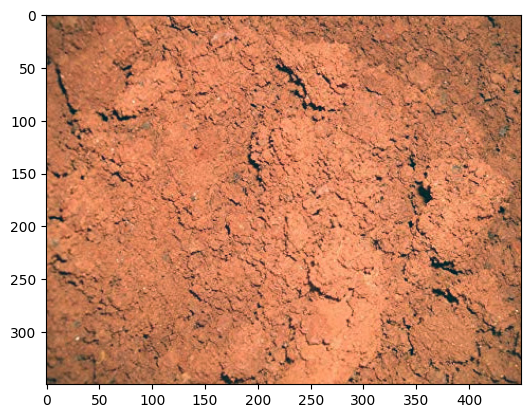

---
Percent Alluvial Soil: 100.0%
Percent Black Soil: 0.0%
Percent Clay Soil: 0.0%
Percent Red Soil: 0.0%
Time to Classify: 1.70091 seconds
---


In [ ]:
classify_percentage(image_fp=percentage_photo)